In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import re
from datetime import datetime


In [2]:
import os,sys
sys.path.insert(0, os.path.abspath('.'))
print(sys.path)

from trace import Request, TraceConfig, generate_synthetic_reqs

['/home/shanyu/sglang/benchmark/multi-model', '/opt/conda/envs/sglang/lib/python39.zip', '/opt/conda/envs/sglang/lib/python3.9', '/opt/conda/envs/sglang/lib/python3.9/lib-dynload', '', '/home/shanyu/.local/lib/python3.9/site-packages', '__editable__.sglang-0.2.10.finder.__path_hook__', '/opt/conda/envs/sglang/lib/python3.9/site-packages']


In [3]:
MODELS = ["meta-llama/Llama-2-7b-chat-hf", "mistralai/Mistral-7B-Instruct-v0.2"]
SEED = 42
MODES = ["swap", "collocate", "single-model"]

In [4]:
def get_trace_config(req_rate, cv, alpha):
    trace_config = TraceConfig(
        req_rate=req_rate,
        duration=60*5,
        input_range=[8, 1024],
        output_range=[8, 512],
        model_paths=MODELS,
        seed=SEED,
        alpha=alpha,
        cv=cv,
    )
    return trace_config

In [5]:
def get_server_files(trace_config):
    server_file_names = {}
    now = "0822"
    for mode in MODES:
        filename = f"{now}_{mode}_duration-{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_input-{trace_config.input_range[0]}-{trace_config.input_range[1]}_output-{trace_config.output_range[0]}-{trace_config.output_range[1]}.log"
        path = os.path.join("server-logs", filename)
        server_file_names[mode] = path
    return server_file_names

In [6]:
def get_results(trace_config,now = "0822", modes=MODES):
    request_tputs = {}
    for mode in modes:
        filename = f"{now}_{mode}_duration_{trace_config.duration}_req_rate-{trace_config.req_rate}_alpha-{trace_config.alpha}_cv-{trace_config.cv}_input-{trace_config.input_range[0]}-{trace_config.input_range[1]}_output-{trace_config.output_range[0]}-{trace_config.output_range[1]}.json"
        path = os.path.join("benchmark-results", filename)
        with open(path, "r") as f:
            result = json.loads(f.readline())
            request_tputs[mode] = result["request_throughput"]     
    return request_tputs       

### Load benchmark result data

In [7]:
result_data = []

req_rates = [0.6, 1, 2, 4, 8]
cv = 1
alphas = [0.1, 0.3, 1]
for req_rate in req_rates:
    for alpha in alphas:
        trace_config = get_trace_config(req_rate, cv, alpha)
        request_tputs = get_results(trace_config)
        result_data.append(dict(req_rate=req_rate, alpha=alpha, cv=cv, **request_tputs))
        print(f"req_rate: {req_rate}, alpha: {alpha}, cv: {cv}")
        print(request_tputs)
        print("")


req_rate: 0.6, alpha: 0.1, cv: 1
{'swap': 0.5486509286469685, 'collocate': 0.5620309314400186, 'single-model': 0.5810684671588261}

req_rate: 0.6, alpha: 0.3, cv: 1
{'swap': 0.5426981757021018, 'collocate': 0.561758489970487, 'single-model': 0.5809744053443121}

req_rate: 0.6, alpha: 1, cv: 1
{'swap': 0.5605510445797124, 'collocate': 0.5586049225015235, 'single-model': 0.5807565593926478}

req_rate: 1, alpha: 0.1, cv: 1
{'swap': 0.8381661187285956, 'collocate': 0.8456930003414752, 'single-model': 0.8821020418442873}

req_rate: 1, alpha: 0.3, cv: 1
{'swap': 0.8362818872280751, 'collocate': 0.8316270854812517, 'single-model': 0.8823647744718622}

req_rate: 1, alpha: 1, cv: 1
{'swap': 0.8165073817093941, 'collocate': 0.8438458426356074, 'single-model': 0.8826800534995818}

req_rate: 2, alpha: 0.1, cv: 1
{'swap': 1.7828266448624304, 'collocate': 1.080571369645262, 'single-model': 1.9065930762663788}

req_rate: 2, alpha: 0.3, cv: 1
{'swap': 1.7378806767619348, 'collocate': 1.151676658898724

In [8]:
req_rates = [0.6, 1, 2, 4, 8]
cv = 1
alphas = [0.6]
for req_rate in req_rates:
    for alpha in alphas:
        trace_config = get_trace_config(req_rate, cv, alpha)
        request_tputs = get_results(trace_config, now="0823", modes=["collocate"])
        request_tputs.update(get_results(trace_config, modes=["swap", "single-model"]))
        result_data.append(dict(req_rate=req_rate, alpha=alpha, cv=cv, **request_tputs))
        print(f"req_rate: {req_rate}, alpha: {alpha}, cv: {cv}")
        print(request_tputs)
        print("")

req_rate: 0.6, alpha: 0.6, cv: 1
{'collocate': 0.5627212466213303, 'swap': 0.5463436390122313, 'single-model': 0.5807843412048821}

req_rate: 1, alpha: 0.6, cv: 1
{'collocate': 0.8397605737251301, 'swap': 0.8341297939880052, 'single-model': 0.8822757276276805}

req_rate: 2, alpha: 0.6, cv: 1
{'collocate': 1.367981089603204, 'swap': 1.7437213342579736, 'single-model': 1.9063692219650752}

req_rate: 4, alpha: 0.6, cv: 1
{'collocate': 1.4367762645528463, 'swap': 2.2216667653268956, 'single-model': 2.369477879761861}

req_rate: 8, alpha: 0.6, cv: 1
{'collocate': 1.4922177995831258, 'swap': 2.5052427858034085, 'single-model': 2.448845259323062}



In [9]:
req_rates = [0.6, 1, 2, 4, 8]
cv = 1
alphas = [0.6]
for req_rate in req_rates:
    for alpha in alphas:
        trace_config = get_trace_config(req_rate, cv, alpha)
        request_tputs_after = get_results(trace_config, now="0823", modes=["collocate"])
        request_tputs_before = get_results(trace_config, now="0822", modes=["collocate"])
        print(f"req_rate: {req_rate}, alpha: {alpha}, cv: {cv}")
        print("before: ", request_tputs_before)
        print("after: ", request_tputs_after)
        print("")


req_rate: 0.6, alpha: 0.6, cv: 1
before:  {'collocate': 0.5628760339729466}
after:  {'collocate': 0.5627212466213303}

req_rate: 1, alpha: 0.6, cv: 1
before:  {'collocate': 0.8395029562398847}
after:  {'collocate': 0.8397605737251301}

req_rate: 2, alpha: 0.6, cv: 1
before:  {'collocate': 1.295640470203166}
after:  {'collocate': 1.367981089603204}

req_rate: 4, alpha: 0.6, cv: 1
before:  {'collocate': 1.5457095311892624}
after:  {'collocate': 1.4367762645528463}

req_rate: 8, alpha: 0.6, cv: 1
before:  {'collocate': 1.6050009507155747}
after:  {'collocate': 1.4922177995831258}



In [10]:

req_rates = [0.6, 1, 2, 4]
alpha = 1 
cvs = [0.1, 2, 4]
for req_rate in req_rates:

    for cv in cvs:
        trace_config = get_trace_config(req_rate, cv, alpha)
        request_tputs = get_results(trace_config)
        result_data.append(dict(req_rate=req_rate, alpha=alpha, cv=cv, **request_tputs))

        print(f"req_rate: {req_rate}, alpha: {alpha}, cv: {cv}")
        print(request_tputs)
        print("")

req_rate: 0.6, alpha: 1, cv: 0.1
{'swap': 0.537818571794848, 'collocate': 0.5571551174105915, 'single-model': 0.5801727082007706}

req_rate: 0.6, alpha: 1, cv: 2
{'swap': 0.42479232247991133, 'collocate': 0.4242029871330768, 'single-model': 0.4397326290506986}

req_rate: 0.6, alpha: 1, cv: 4
{'swap': 0.40625840430941385, 'collocate': 0.4056409011834823, 'single-model': 0.41675967729803104}

req_rate: 1, alpha: 1, cv: 0.1
{'swap': 0.9079084852915205, 'collocate': 0.9352921461797922, 'single-model': 0.9636489204323149}

req_rate: 1, alpha: 1, cv: 2
{'swap': 0.8945600494703864, 'collocate': 0.9254310842322117, 'single-model': 0.9711081236354114}

req_rate: 1, alpha: 1, cv: 4
{'swap': 0.952772957021656, 'collocate': 0.9302652945300445, 'single-model': 1.0070659379972415}

req_rate: 2, alpha: 1, cv: 0.1
{'swap': 1.7548815997913412, 'collocate': 1.5030727699016837, 'single-model': 1.8838680262653034}

req_rate: 2, alpha: 1, cv: 2
{'swap': 1.8069882408633011, 'collocate': 1.4944268392450673, 

In [11]:
df = pd.DataFrame(result_data)

## Throughputs Analysis

### Proformance vs Request Rate and alpha (cv = 1)

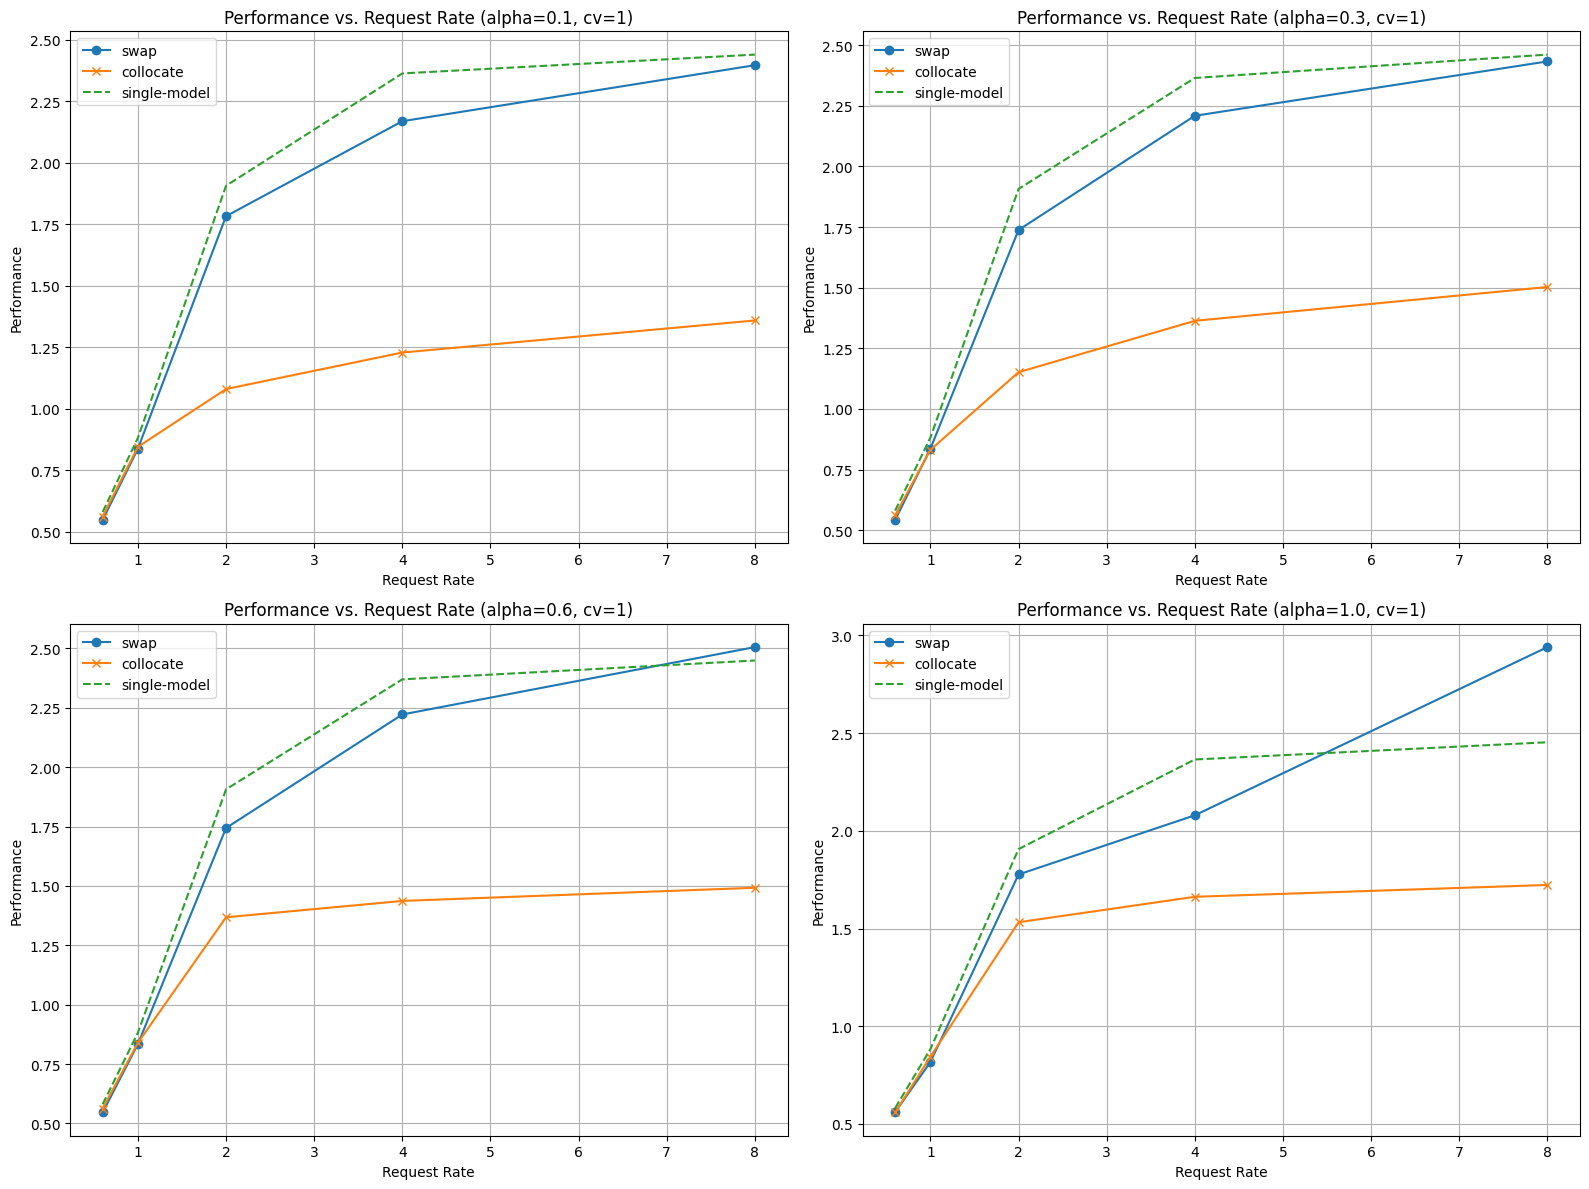

In [12]:
import matplotlib.pyplot as plt

# Get the unique alpha values
alpha_values = sorted(df['alpha'].unique())

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the 2x2 array for easier iteration

# Loop through each alpha value and corresponding subplot axis
for i, alpha in enumerate(alpha_values):
    subset = df[(df['alpha'] == alpha) & (df['cv'] == 1)]  # Filter by alpha and cv
    ax = axes[i]  # Select the current subplot
    
    # Plot the data
    ax.plot(subset['req_rate'], subset['swap'], label='swap', marker='o')
    ax.plot(subset['req_rate'], subset['collocate'], label='collocate', marker='x')
    ax.plot(subset['req_rate'], subset['single-model'], label='single-model', linestyle='--')

    # Set labels and title for each subplot
    ax.set_xlabel('Request Rate')
    ax.set_ylabel('Performance')
    ax.set_title(f'Performance vs. Request Rate (alpha={alpha}, cv=1)')
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


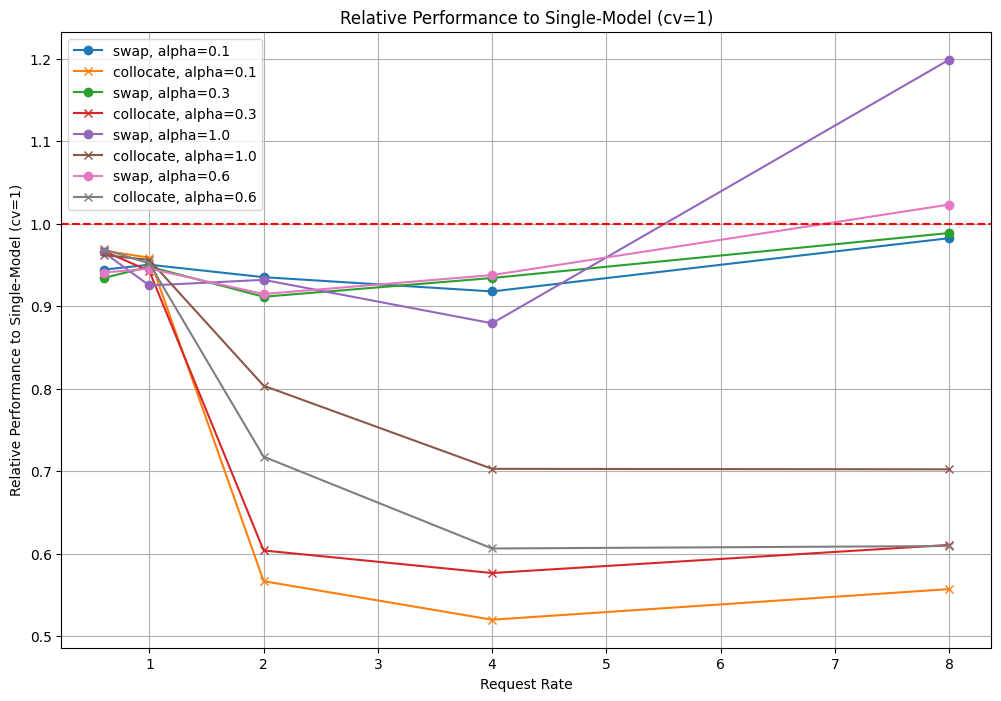

In [13]:
# 3. Relative Performance to Single-Model
df['swap_relative'] = df['swap'] / df['single-model']
df['collocate_relative'] = df['collocate'] / df['single-model']

plt.figure(figsize=(12, 8))
for alpha in df['alpha'].unique():
    subset = df[(df['alpha'] == alpha) & (df['cv'] == 1)]
    plt.plot(subset['req_rate'], subset['swap_relative'], label=f'swap, alpha={alpha}', marker='o')
    plt.plot(subset['req_rate'], subset['collocate_relative'], label=f'collocate, alpha={alpha}', marker='x')

plt.axhline(1, color='red', linestyle='--')


plt.xlabel('Request Rate')
plt.ylabel('Relative Performance to Single-Model (cv=1)')
plt.title('Relative Performance to Single-Model (cv=1)')
plt.legend()
plt.grid(True)
plt.show()

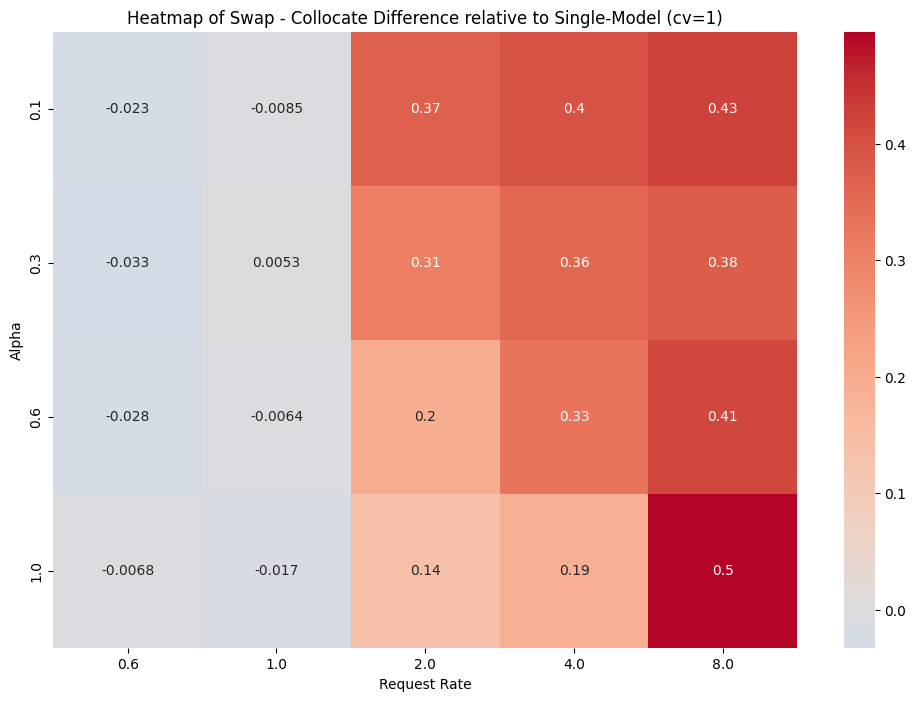

In [14]:
import seaborn as sns

df['swap_collocate_relative_diff'] = df['swap_relative'] - df['collocate_relative']
# df['swap_collocate_diff_relative'] = (df['swap'] - df['collocate'])/ df['single-model']


pivot_table = df.pivot_table(index='alpha', columns='req_rate', values='swap_collocate_relative_diff')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Swap - Collocate Difference relative to Single-Model (cv=1)')
plt.xlabel('Request Rate')
plt.ylabel('Alpha')
plt.show()

### Proformance vs Request Rate and cv (alpha = 1)

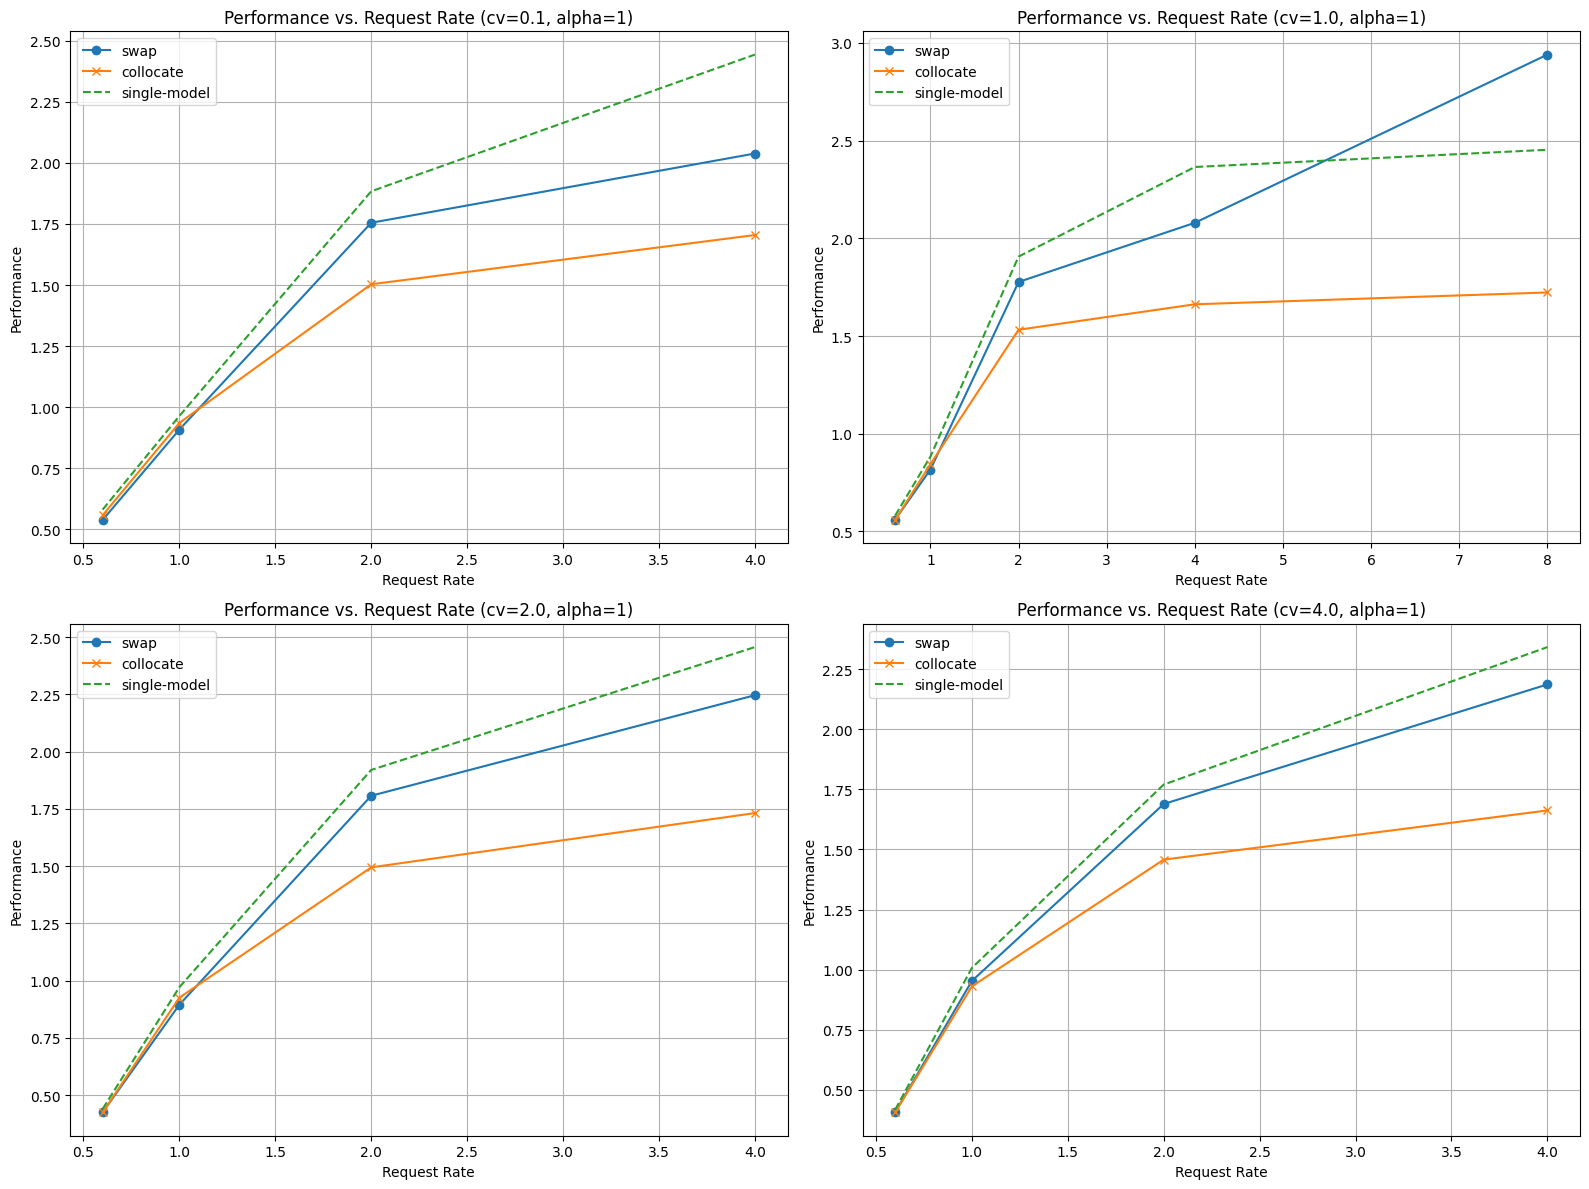

In [15]:
import matplotlib.pyplot as plt

# Get the unique cv values
cv_values = sorted(df['cv'].unique())

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the 2x2 array for easier iteration

# Loop through each cv value and corresponding subplot axis
for i, cv in enumerate(cv_values):
    subset = df[(df['cv'] == cv) & (df['alpha'] == 1)]  # Filter by alpha and cv
    ax = axes[i]  # Select the current subplot
    
    # Plot the data
    ax.plot(subset['req_rate'], subset['swap'], label='swap', marker='o')
    ax.plot(subset['req_rate'], subset['collocate'], label='collocate', marker='x')
    ax.plot(subset['req_rate'], subset['single-model'], label='single-model', linestyle='--')

    # Set labels and title for each subplot
    ax.set_xlabel('Request Rate')
    ax.set_ylabel('Performance')
    ax.set_title(f'Performance vs. Request Rate (cv={cv}, alpha=1)')
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


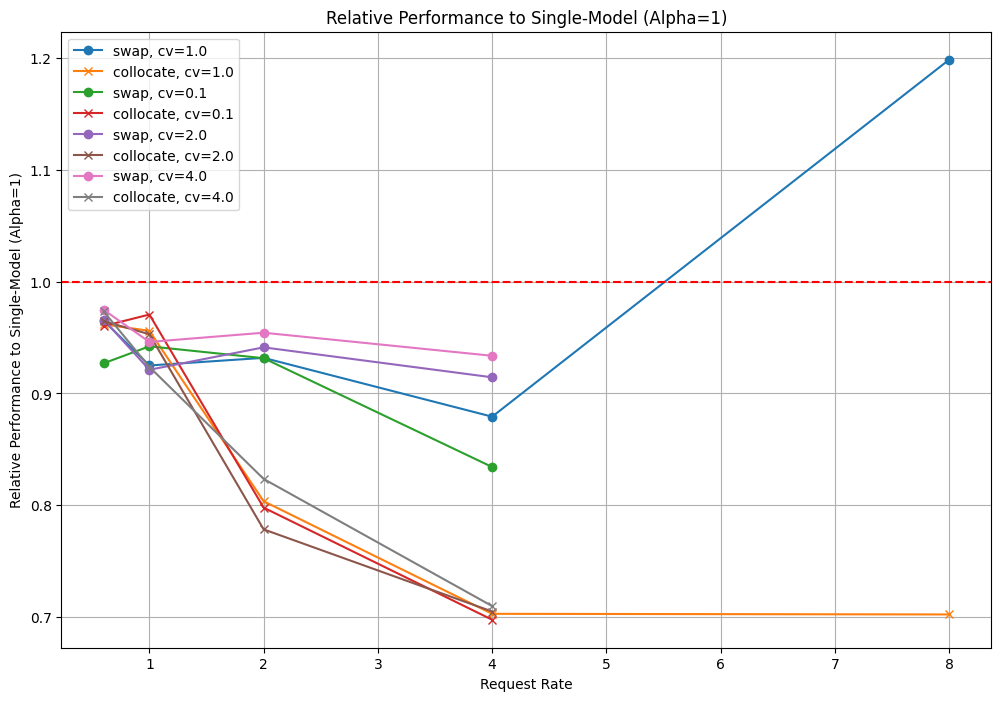

In [16]:
# 3. Relative Performance to Single-Model
df['swap_relative'] = df['swap'] / df['single-model']
df['collocate_relative'] = df['collocate'] / df['single-model']

plt.figure(figsize=(12, 8))
for cv in df['cv'].unique():
    subset = df[(df['cv'] == cv) & (df['alpha'] == 1)]
    plt.plot(subset['req_rate'], subset['swap_relative'], label=f'swap, cv={cv}', marker='o')
    plt.plot(subset['req_rate'], subset['collocate_relative'], label=f'collocate, cv={cv}', marker='x')

plt.axhline(1, color='red', linestyle='--')

plt.xlabel('Request Rate')
plt.ylabel('Relative Performance to Single-Model (Alpha=1)')
plt.title('Relative Performance to Single-Model (Alpha=1)')
plt.legend()
plt.grid(True)
plt.show()

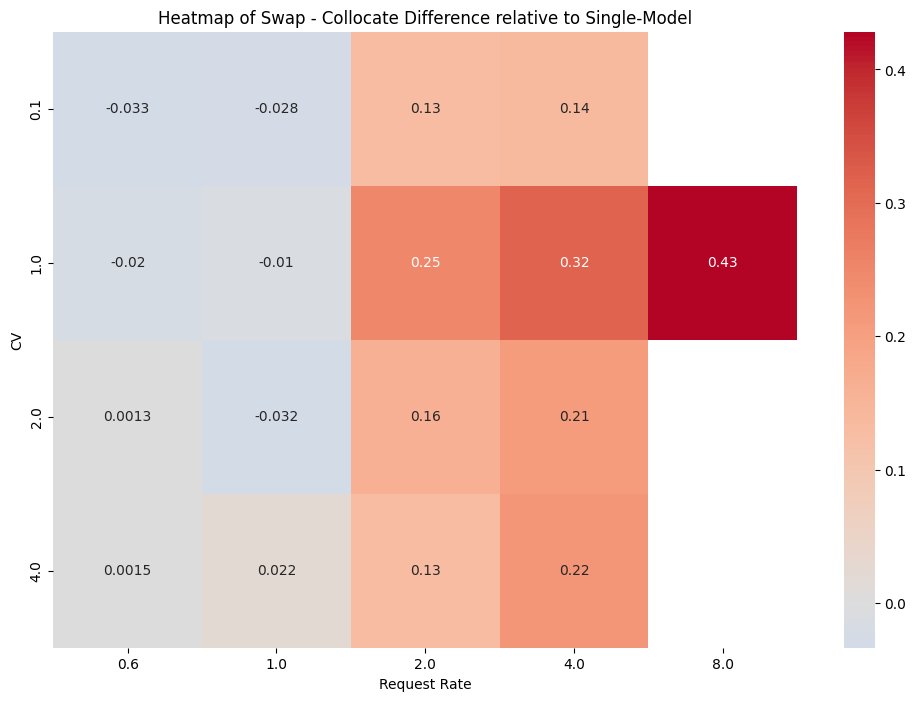

In [17]:
import seaborn as sns

df['swap_collocate_relative_diff'] = df['swap_relative'] - df['collocate_relative']
# df['swap_collocate_diff_relative'] = (df['swap'] - df['collocate'])/ df['single-model']


pivot_table = df.pivot_table(index='cv', columns='req_rate', values='swap_collocate_relative_diff')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Swap - Collocate Difference relative to Single-Model')
plt.xlabel('Request Rate')
plt.ylabel('CV')
plt.show()

## Running Batch Size Analysis

In [31]:
def get_batch_info(req_rate, cv, alpha, mode):
    trace_config = get_trace_config(req_rate, cv, alpha)
    server_file_names = get_server_files(trace_config)
    log_file_path = server_file_names[mode]
    # Compile regex patterns for parsing
    decode_pattern = re.compile(
        r'(?P<timestamp>\d+:\d+:\d+,\d+).* \[(?P<model_name>[^\]]+)\]\[gpu=.*?] Decode batch\. #running-req: (?P<running_req>\d+), #token: (?P<token_count>\d+), token usage: (?P<token_usage>[\d\.]+),'
    )
    switch_decision_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).*Prepare to switch (?P<action>on|off) model (?P<model_name>[^\s]+)')
    switch_on_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).* Switching on model (?P<model_name>[^\s]+)')
    switch_off_pattern = re.compile(
        r'(?P<timestamp>\d+:\d+:\d+,\d+).* \[time=\d+\.\d+\]\[model_name=(?P<model_name>[^\]]+)\]\[gpu_id=.*?\] swap out model'
    )

    request_pattern = re.compile(r'(?P<timestamp>\d+:\d+:\d+,\d+).* is put into the queue of model (?P<model_name>[^\s]+)')

    # Store parsed data
    decode_data = []
    switch_decisions = []
    switch_periods = {}
    model_status = {}
    request_data = []

    # Read and parse the log file
    with open(log_file_path, 'r') as file:
        for line in file:
            decode_match = decode_pattern.search(line)
            if decode_match:
                timestamp = datetime.strptime(decode_match.group('timestamp'), '%H:%M:%S,%f')
                model_name = decode_match.group('model_name')
                running_req = int(decode_match.group('running_req'))
                token_usage = float(decode_match.group('token_usage'))
                decode_data.append([timestamp, model_name, running_req, token_usage])
                for model, status in model_status.items():
                    if status == 'off':
                        decode_data.append([timestamp, model, 0, 0])
            
            switch_decision_match = switch_decision_pattern.search(line)
            if switch_decision_match:
                timestamp = datetime.strptime(switch_decision_match.group('timestamp'), '%H:%M:%S,%f')
                action = switch_decision_match.group('action')
                model_name = switch_decision_match.group('model_name')
                switch_decisions.append([timestamp, action, model_name])
            
            switch_off_match = switch_off_pattern.search(line)
            if switch_off_match:
                timestamp = datetime.strptime(switch_off_match.group('timestamp'), '%H:%M:%S,%f')
                model_full_name = switch_off_match.group('model_name')
                model_name = model_full_name.split('/')[-1]

                model_status[model_name] = 'off'
                if model_name not in switch_periods:
                    switch_periods[model_name] = []
                switch_periods[model_name].append({'off': timestamp})
                decode_data.append([timestamp, model_name, 0, 0])
            
            switch_on_match = switch_on_pattern.search(line)
            if switch_on_match:
                timestamp = datetime.strptime(switch_on_match.group('timestamp'), '%H:%M:%S,%f')
                model_full_name = switch_on_match.group('model_name')
                model_name = model_full_name.split('/')[-1]
                model_status[model_name] = 'on'
                if model_name in switch_periods and switch_periods[model_name]:
                    switch_periods[model_name][-1]['on'] = timestamp

            request_match = request_pattern.search(line)
            if request_match:
                timestamp = datetime.strptime(request_match.group('timestamp'), '%H:%M:%S,%f')
                model_name = request_match.group('model_name')
                request_data.append([timestamp, model_name])

    # Convert decode data to a DataFrame
    decode_df = pd.DataFrame(decode_data, columns=['timestamp', 'model_name', 'running_req', 'token_usage'])
    switch_df = pd.DataFrame(switch_decisions, columns=['timestamp', 'action', 'model_name'])
    request_df = pd.DataFrame(request_data, columns=['timestamp', 'model_name'])

    # Convert timestamp to seconds starting from 0
    start_time = min(decode_df['timestamp'].min(), request_df['timestamp'].min())
    decode_df['timestamp_seconds'] = decode_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())
    switch_df['timestamp_seconds'] = switch_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())
    request_df['timestamp_seconds'] = request_df['timestamp'].apply(lambda x: (x - start_time).total_seconds())

    # Derive the model off and another on period from the switch df
    last_action = None
    decision_preriods = {"off_on": [], "on_off": []}
    if mode == "swap":
        for i, row in switch_df.iterrows():
            if last_action is None:
                last_action = row['action']
            else:
                if last_action == 'off' and row['action'] == 'on':
                    decision_preriods["off_on"].append((switch_df.loc[i-1, 'timestamp_seconds'], row['timestamp_seconds']))
                    last_action = None
                elif last_action == 'on' and row['action'] == 'off':
                    decision_preriods["on_off"].append((switch_df.loc[i-1, 'timestamp_seconds'], row['timestamp_seconds']))
                    last_action = None
        # append the last action to the end of switch_df
        if last_action == 'off':
            decision_preriods["off_on"].append((switch_df.loc[i, 'timestamp_seconds'], decode_df['timestamp_seconds'].max()))
        else:
            decision_preriods["on_off"].append((switch_df.loc[i, 'timestamp_seconds'], decode_df['timestamp_seconds'].max()))
        
    # Round timestamp_seconds to 1 second granularity
    request_df['timestamp_seconds'] = request_df['timestamp_seconds'].round(2)
    df_request_counts = request_df.groupby(['timestamp_seconds', 'model_name']).size().unstack(fill_value=0)

    # align the last timestamp of the decode_df to the last timestamp of the request_df
    last_request_timestamp = request_df['timestamp_seconds'].max() + 1
    df_request_counts.loc[last_request_timestamp] = 0

    last_decode_timestamp = decode_df['timestamp_seconds'].max()
    df_request_counts.loc[last_decode_timestamp] = 0


    return decode_df, decision_preriods, df_request_counts

In [25]:
def plot_batch_info(req_rate, cv, alpha, mode):
    decode_data, switch_decisions, request_data = get_batch_info(req_rate, cv, alpha, mode)
    # plot 3*1 subplots for number of requests, token usage, and number of running requests
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # Figure 1: Plot the number of running requests over time for each model
    for model_name in decode_data['model_name'].unique():
        subset = decode_data[decode_data['model_name'] == model_name]
        axes[0].plot(subset['timestamp_seconds'], subset['running_req'], label=model_name)

    # plot the switch off and on periods
    for period in switch_decisions["off_on"]:
        axes[0].axvspan(period[0], period[1], color='red', alpha=0.3)
    for period in switch_decisions["on_off"]:
        axes[0].axvline(period[0], color='red', linestyle='--')
        axes[0].axvline(period[1], color='red', linestyle='--')

    axes[0].set_ylabel('Number of Running Requests')
    axes[0].set_title('Number of Running Requests Over Time')
    axes[0].legend()
    axes[0].grid(True)

    # Figure 2: Plot the token usage over time for each model
    for model_name in decode_data['model_name'].unique():
        subset = decode_data[decode_data['model_name'] == model_name]
        axes[1].plot(subset['timestamp_seconds'], subset['token_usage'], label=model_name)

    axes[1].set_ylabel('Token Usage')
    axes[1].set_title('Token Usage Over Time')
    axes[1].legend()
    axes[1].grid(True)

    # Figure 3: Plot the number of requests over time for each model
    request_data = request_data.fillna(0)
    for model_name in request_data.columns:
        axes[2].plot(request_data.index, request_data[model_name], label=model_name)

    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Number of Requests')
    axes[2].set_title('Number of Requests Over Time')
    axes[2].legend()
    axes[2].grid(True)

    plt.suptitle(f'Batch Information: Request Rate={req_rate}, CV={cv}, Alpha={alpha}, Mode={mode}')
    plt.show()

Throughput for each mode:
Collocate:  0.8438458426356074 req/s
Swap:  0.8165073817093941 req/s
Single-Model:  0.8826800534995818 req/s


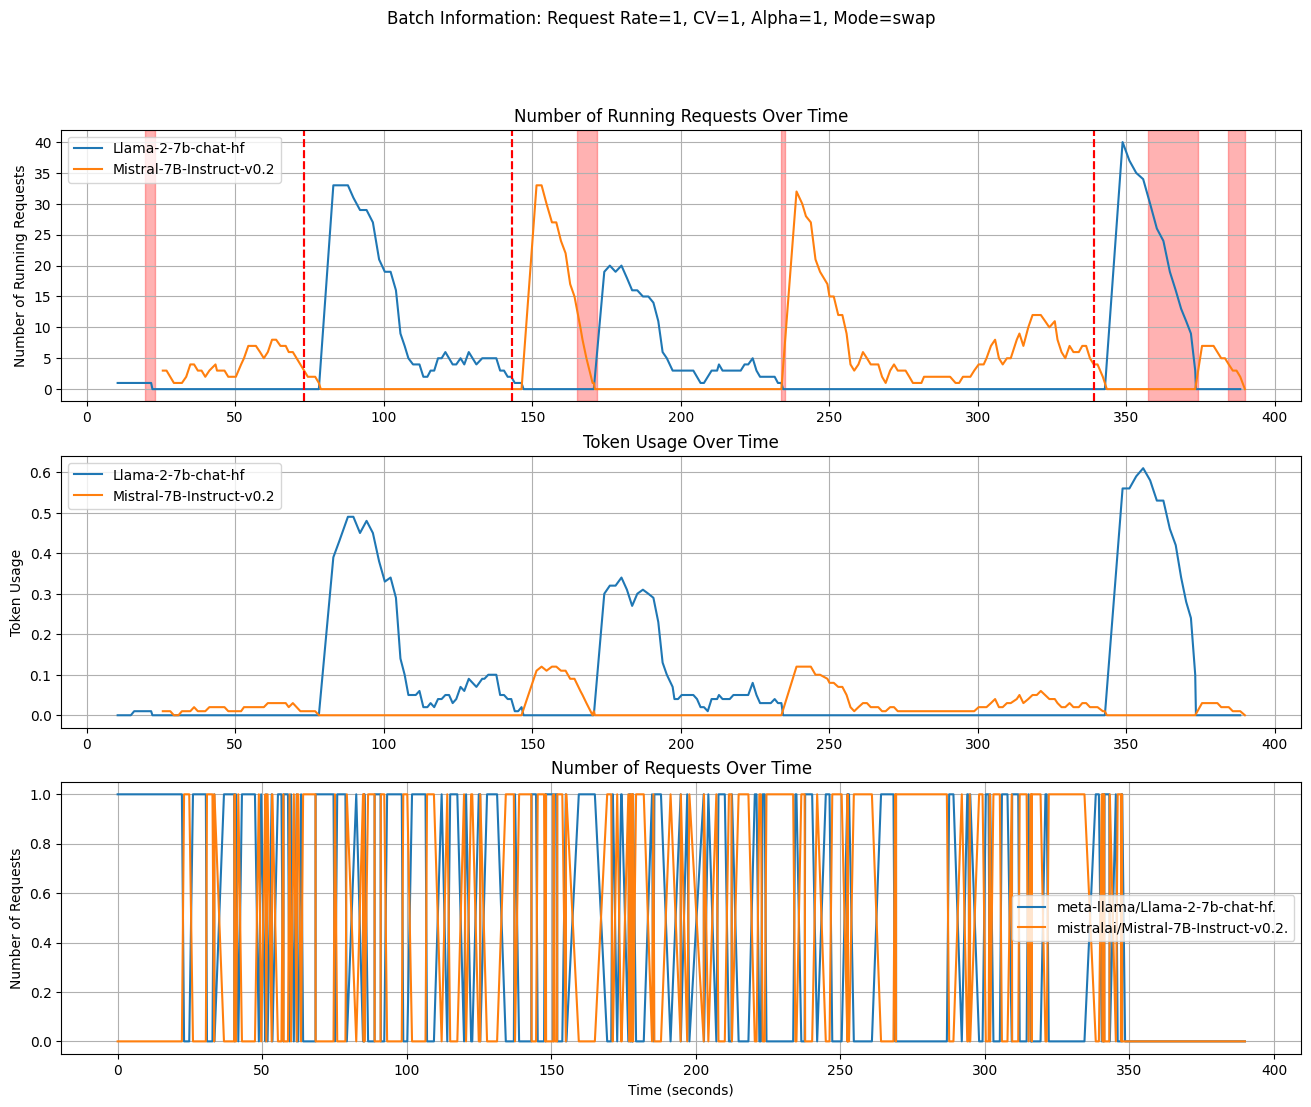

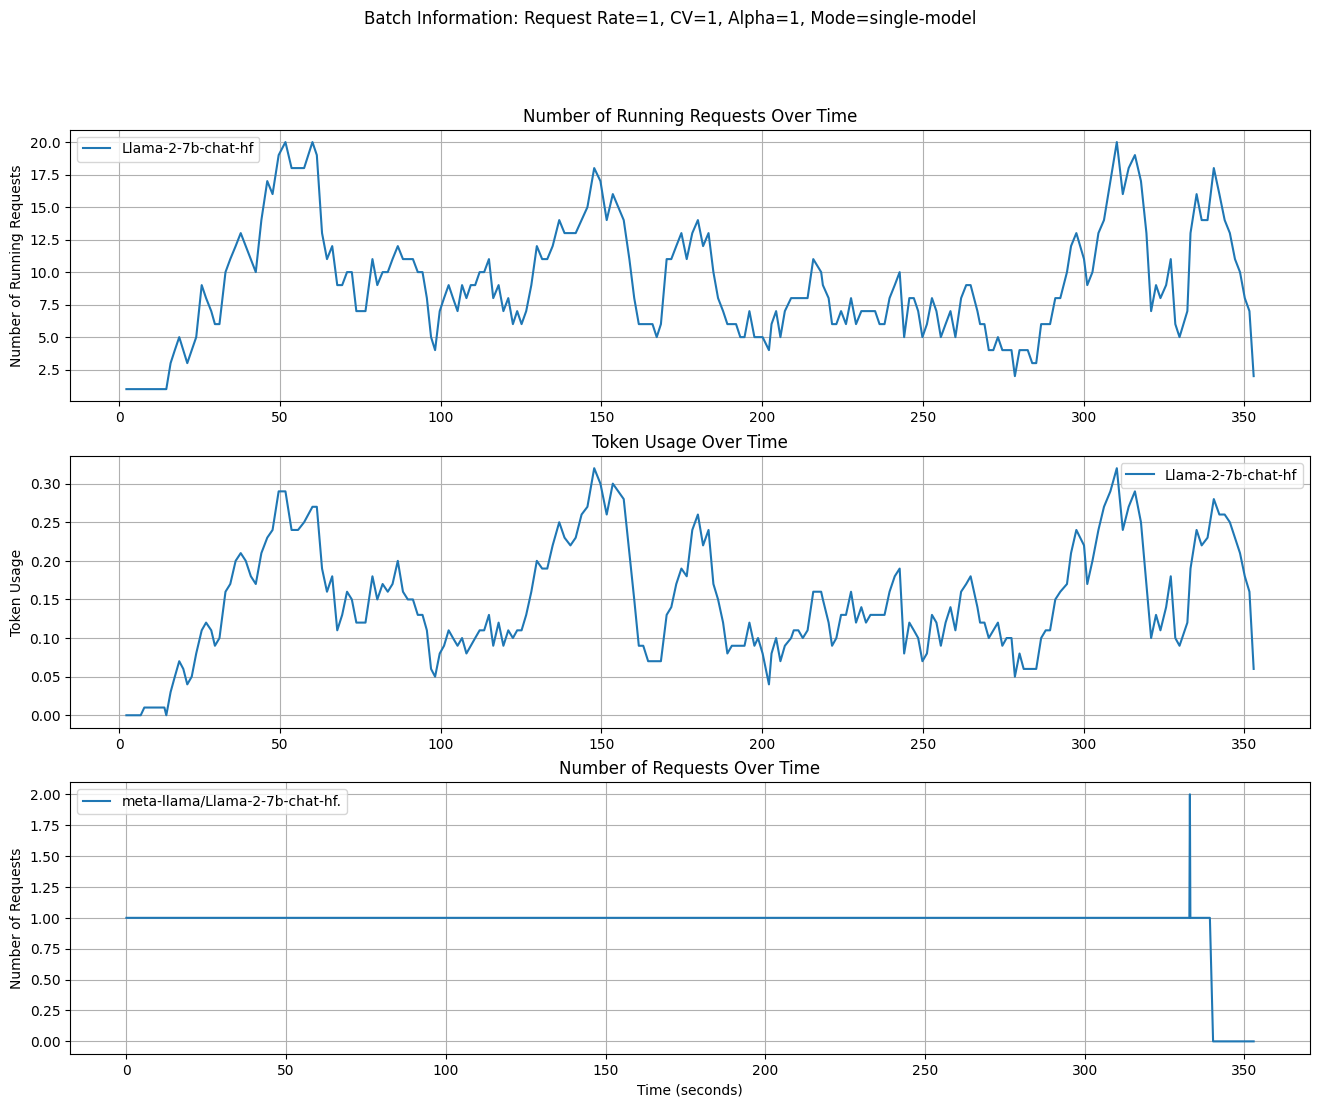

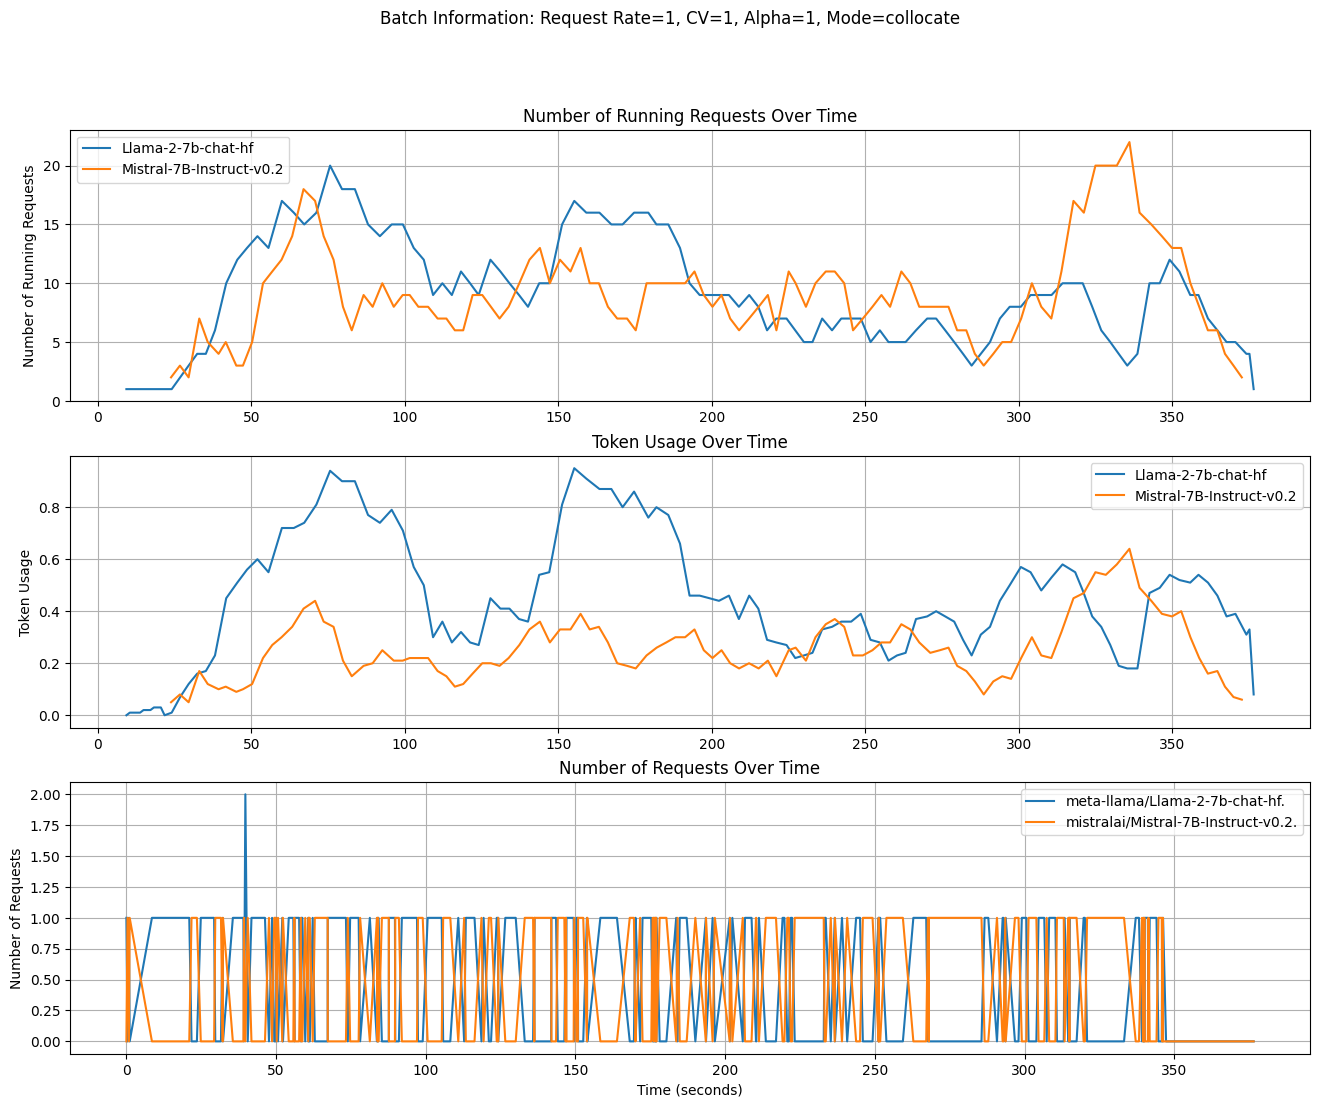

In [38]:
req_rate = 1
cv = 1
alpha = 1

tputs = df[(df['req_rate'] == req_rate) & (df['cv'] == cv) & (df['alpha'] == alpha)].iloc[0]
print("Throughput for each mode:")
print("Collocate: ", tputs['collocate'], "req/s")
print("Swap: ", tputs['swap'], "req/s")
print("Single-Model: ", tputs['single-model'], "req/s")

plot_batch_info(req_rate, cv, alpha, 'swap')
plot_batch_info(req_rate, cv, alpha, 'single-model')
plot_batch_info(req_rate, cv, alpha, 'collocate')

Throughput for each mode:
Collocate:  1.7230392110605097 req/s
Swap:  2.9405584345534868 req/s
Single-Model:  2.4534423508491043 req/s


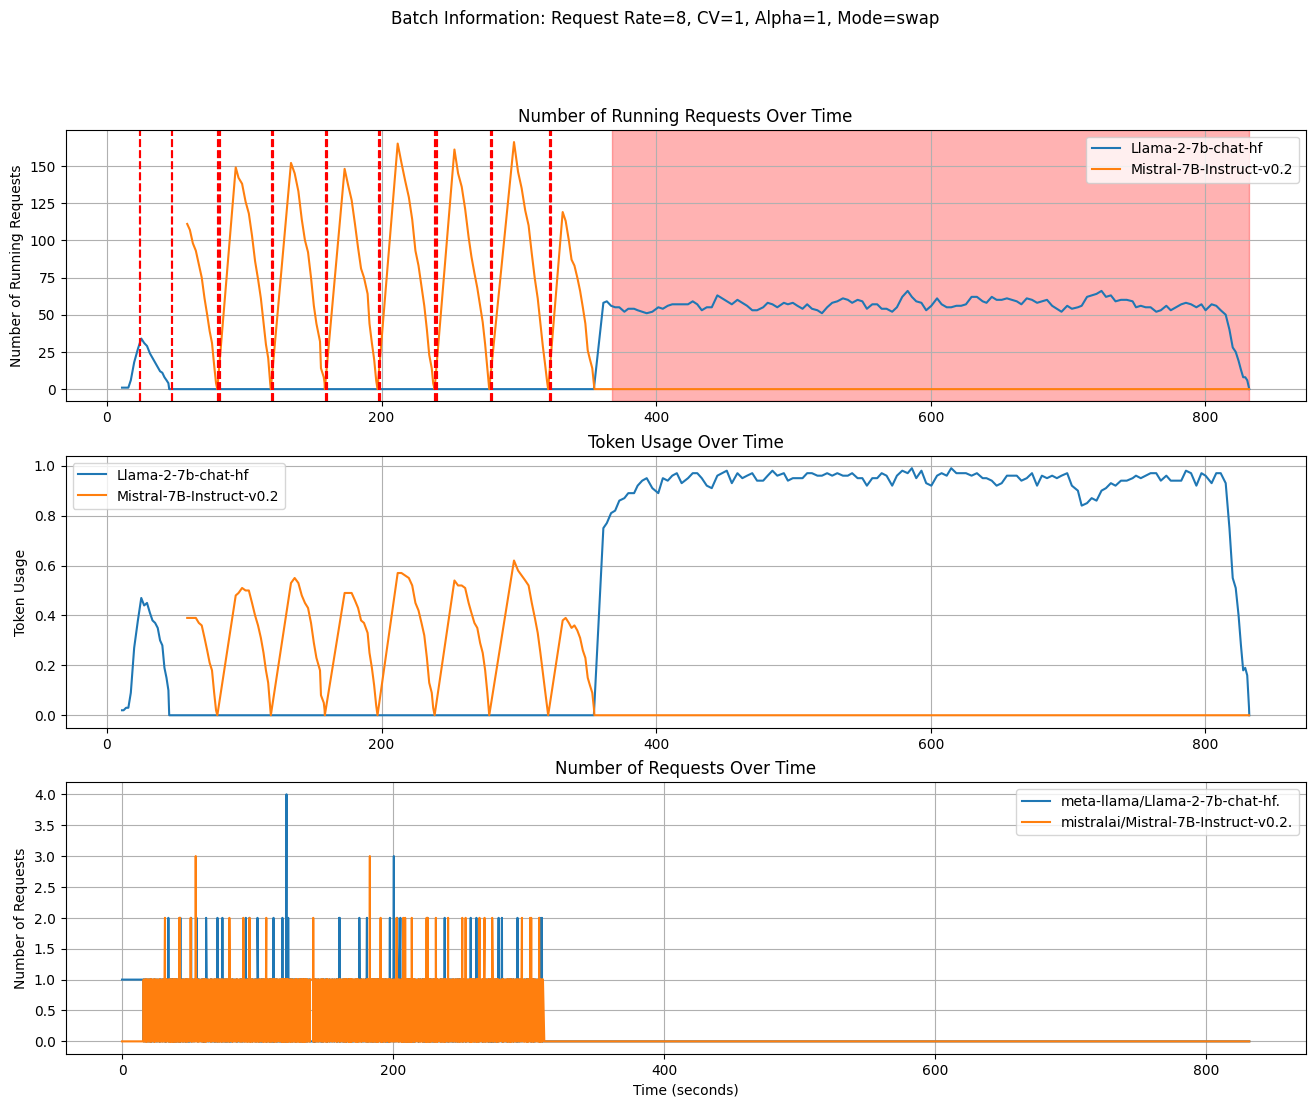

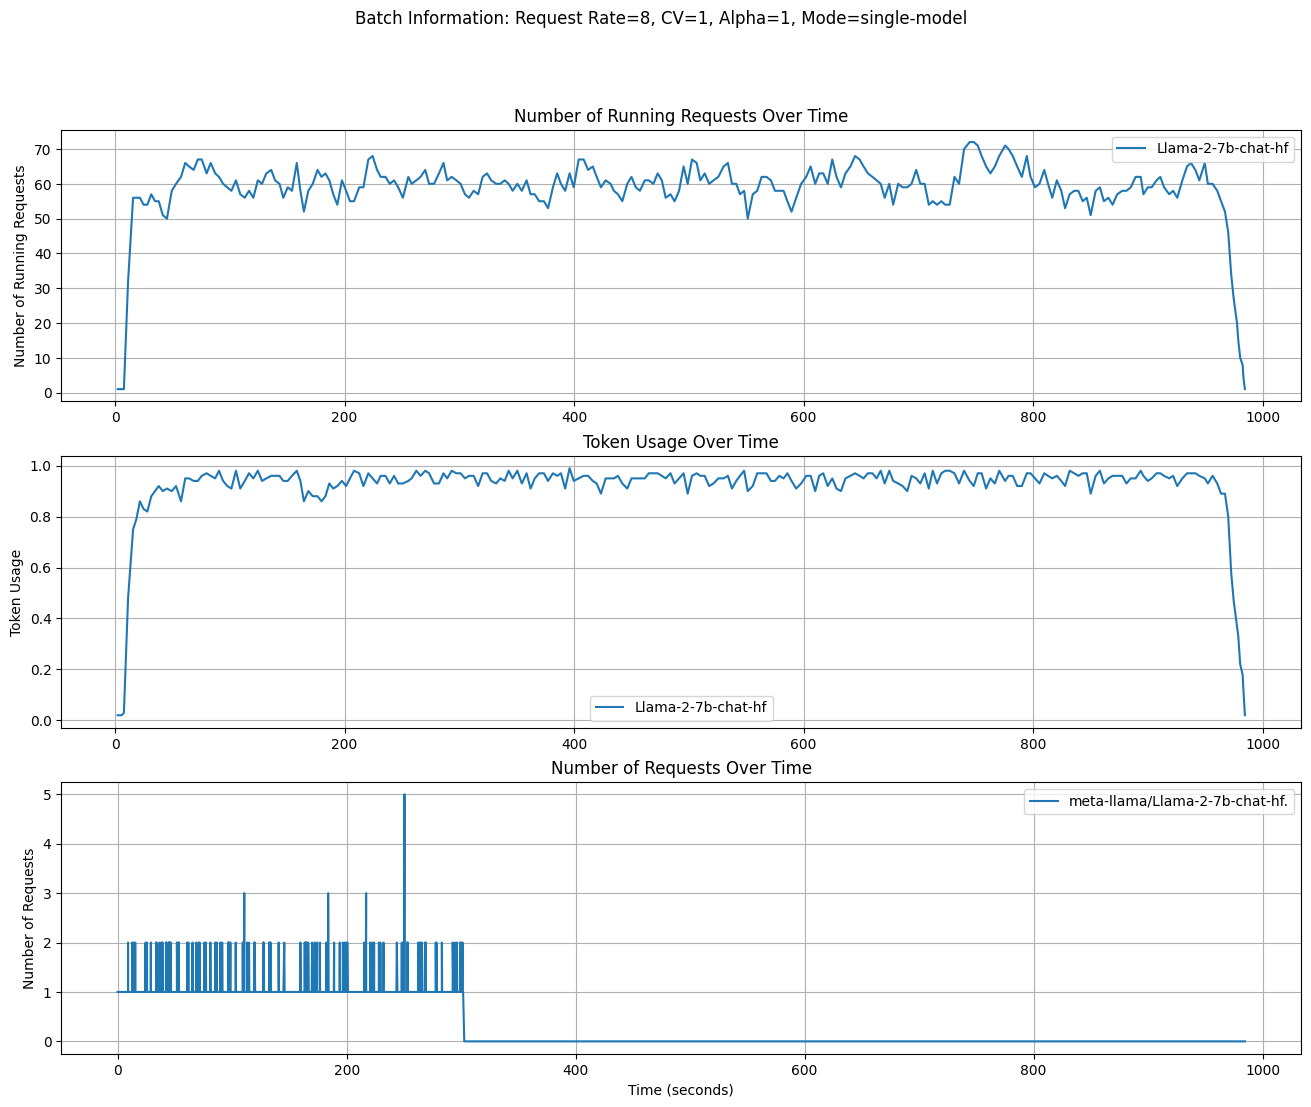

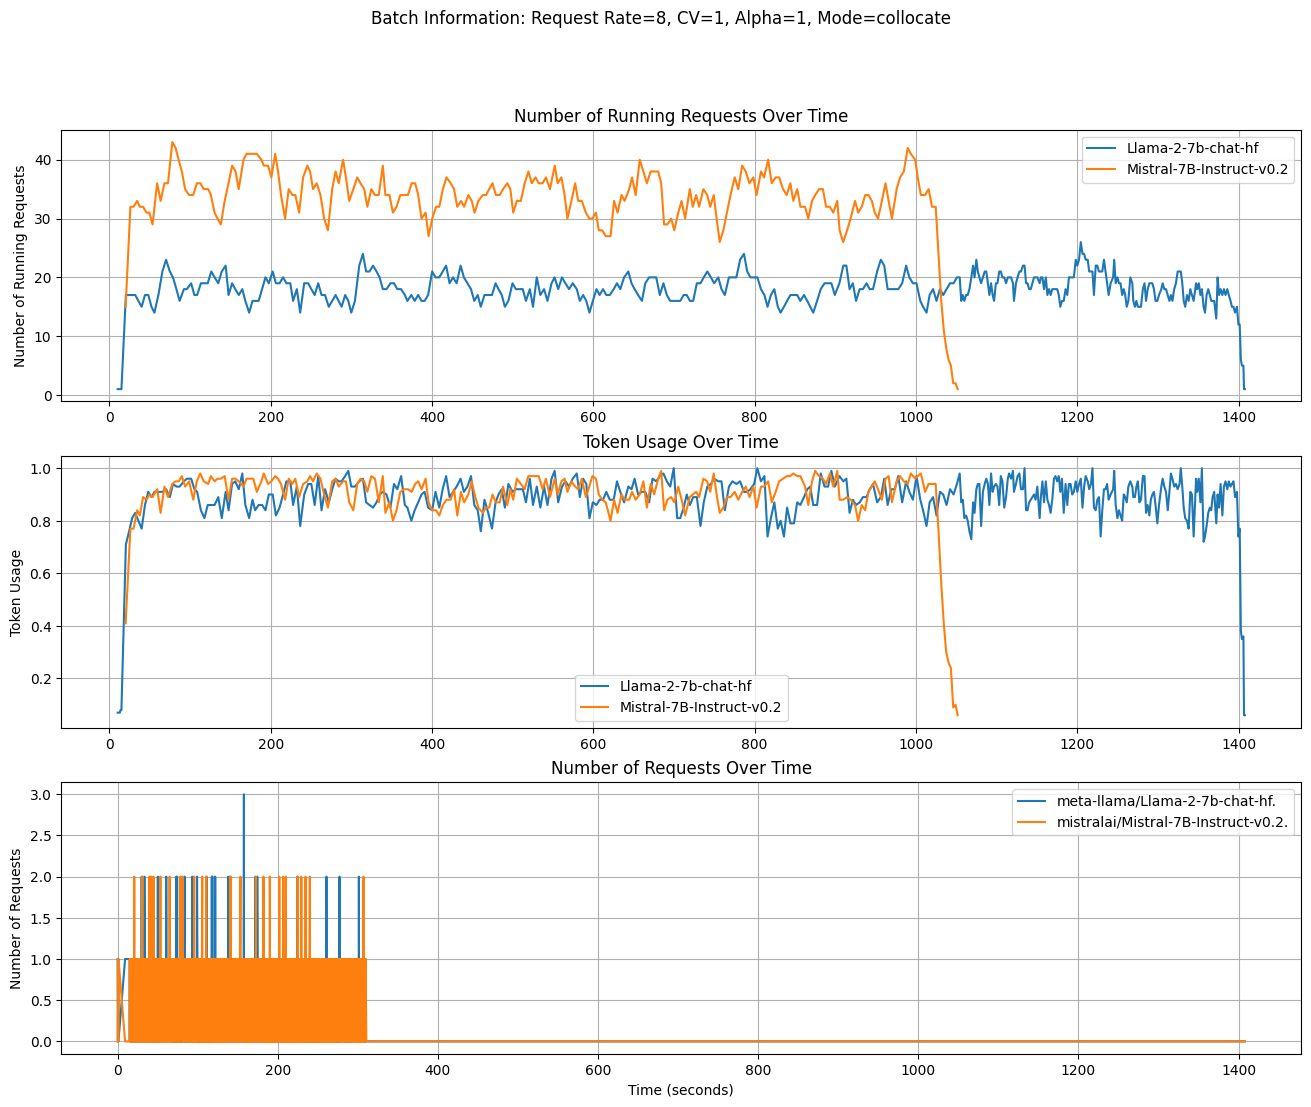

In [37]:
req_rate = 8
cv = 1
alpha = 1

tputs = df[(df['req_rate'] == req_rate) & (df['cv'] == cv) & (df['alpha'] == alpha)].iloc[0]
print("Throughput for each mode:")
print("Collocate: ", tputs['collocate'], "req/s")
print("Swap: ", tputs['swap'], "req/s")
print("Single-Model: ", tputs['single-model'], "req/s")

plot_batch_info(req_rate, cv, alpha, 'swap')
plot_batch_info(req_rate, cv, alpha, 'single-model')
plot_batch_info(req_rate, cv, alpha, 'collocate')